# pip install dependencies

In [1]:
!pip install rasterio
!pip install opencv-python
!pip install numpy
!pip install Pillow
!pip install matplotlib
!pip install tensorflow
!pip install scipy
!pip install fastdtw

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# imports

In [2]:
import os
import copy
from pathlib import Path
from itertools import product, chain

import cv2
import rasterio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf

from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.spatial import ConvexHull, convex_hull_plot_2d

%matplotlib inline

2023-02-18 11:28:58.010610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-18 11:28:58.779000: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ubuntu/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-18 11:28:58.779017: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-18 11:29:00.618541: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

In [3]:
!ls

Water-Body-Detection


# process images

In [4]:
images_path = "Water-Body-Detection/NDWI/Satellite Images"

images_path_dictionary = {}

for path in os.listdir(images_path):
    if path != "desktop.ini" and path != "group.py":
        for image in os.listdir(os.path.join(images_path, path)):
            images_name_array = []
            if image.endswith("_B3.TIF"):
                image_path = os.path.join(images_path, path, image)
                images_name_array.append(image_path)
                images_name_array.append(image_path.replace("_B3.TIF", "_B5.TIF"))
                images_name_array.append(image_path.replace("_B3.TIF", "_B6.TIF"))
                images_name_array.append(image_path.replace("_B3.TIF", "_B7.TIF"))

                images_path_dictionary[image.replace("_B3.TIF", "")] = images_name_array

In [5]:
import multiprocessing as mp

def run(i):
    band3 = rasterio.open(images_path_dictionary[i][0])
    band5 = rasterio.open(images_path_dictionary[i][1])
    band6 = rasterio.open(images_path_dictionary[i][2])
    band7 = rasterio.open(images_path_dictionary[i][3])

    green = band3.read(1).astype("float32")
    nir = band5.read(1).astype("float32")
    swir1 = band6.read(1).astype("float32")
    swir2 = band7.read(1).astype("float32")

    ndwi_nir = np.where(
        (green+nir) == 0.,
        0,
        (green-nir)/(green+nir)
    )

    ndwi_swir1 = np.where(
        (green+swir1) == 0.,
        0,
        (green-swir1)/(green+swir1)
    )

    ndwi_swir2 = np.where(
        (green+swir2) == 0.,
        0,
        (green-swir2)/(green+swir2)
    )

    ndwi_nir_copy = copy.copy(ndwi_nir)
    ndwi_nir_copy[ndwi_nir > 0] = -100
    ndwi_nir_copy[ndwi_nir <= 0] = 0

    ndwi_swir1_copy = copy.copy(ndwi_swir1)
    ndwi_swir1_copy[ndwi_swir1 > 0] = -100
    ndwi_swir1_copy[ndwi_swir1 <= 0] = 0

    ndwi_swir2_copy = copy.copy(ndwi_swir2)
    ndwi_swir2_copy[ndwi_swir2 > 0] = -100
    ndwi_swir2_copy[ndwi_swir2 <= 0] = 0

    return [ndwi_nir_copy, ndwi_swir1_copy, ndwi_swir2_copy]

images_path_dictionary_keys = images_path_dictionary.keys()
p=mp.Pool(16)
data = p.map(run, images_path_dictionary_keys)
p.close()
p.join()

/tmp/ipykernel_2061/1180868198.py:17: RuntimeWarning: invalid value encountered in divide
  (green-nir)/(green+nir)
/tmp/ipykernel_2061/1180868198.py:23: RuntimeWarning: invalid value encountered in divide
  (green-swir1)/(green+swir1)
/tmp/ipykernel_2061/1180868198.py:29: RuntimeWarning: invalid value encountered in divide
  (green-swir2)/(green+swir2)
/tmp/ipykernel_2061/1180868198.py:17: RuntimeWarning: invalid value encountered in divide
  (green-nir)/(green+nir)
/tmp/ipykernel_2061/1180868198.py:23: RuntimeWarning: invalid value encountered in divide
  (green-swir1)/(green+swir1)
/tmp/ipykernel_2061/1180868198.py:29: RuntimeWarning: invalid value encountered in divide
  (green-swir2)/(green+swir2)
/tmp/ipykernel_2061/1180868198.py:17: RuntimeWarning: invalid value encountered in divide
  (green-nir)/(green+nir)
/tmp/ipykernel_2061/1180868198.py:17: RuntimeWarning: invalid value encountered in divide
  (green-nir)/(green+nir)
/tmp/ipykernel_2061/1180868198.py:17: RuntimeWarning: in

In [6]:
ndwi_dictionary = {}

for i in range(len(data)):
    ndwi_dictionary[list(images_path_dictionary_keys)[i]] = data[i]

#data = []

In [9]:
processed_images_path = "Water-Body-Detection/NDWI/Processed Images"

def run_save(m):
    for n in range(3):
        img = cv2.threshold(
            np.uint8(ndwi_dictionary[m][n]), 0, 255, cv2.THRESH_BINARY)[1]

        nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
            img)
        sizes = stats[1:, -1]
        nb_components = nb_components - 1

        min_size = 100 * (n+1)

        ndwi_components = np.zeros((output.shape))
        for i in range(0, nb_components):
            if sizes[i] >= min_size:
                ndwi_components[output == i + 1] = -100

        if n == 0:
            img_save_path = os.path.join(
                processed_images_path, (m + "_nir" + ".png"))
        elif n == 1:
            img_save_path = os.path.join(
                processed_images_path, (m + "_swir1" + ".png"))
        elif n == 2:
            img_save_path = os.path.join(
                processed_images_path, (m + "_swir2" + ".png"))

        plt.imsave(img_save_path, ndwi_components, format="png")

p=mp.Pool(16)
p.map(run_save, images_path_dictionary.keys())
p.close()
p.join()

In [10]:
processed_lake_images_path = "Water-Body-Detection/NDWI/Processed Lake Images"

kernel = np.ones((6,6), np.uint8)

def run_save_lake(m):
    for n in range(3):
        if n == 1:
            img = cv2.threshold(
                np.uint8(ndwi_dictionary[m][n]), 0, 255, cv2.THRESH_BINARY)[1]

            img = cv2.erode(img, kernel, iterations=4)
            img = cv2.dilate(img, kernel, iterations=7)

            nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(
                img)
            sizes = stats[1:, -1]
            nb_components = nb_components - 1

            min_size = max(sizes)

            ndwi_components = np.zeros((output.shape))
            for i in range(0, nb_components):
                if sizes[i] >= min_size:
                    ndwi_components[output == i + 1] = -100

            if n == 0:
                img_save_path = os.path.join(
                    processed_lake_images_path, (m + "_nir" + ".png"))
            elif n == 1:
                img_save_path = os.path.join(
                    processed_lake_images_path, (m + "_swir1" + ".png"))
            elif n == 2:
                img_save_path = os.path.join(
                    processed_lake_images_path, (m + "_swir2" + ".png"))

            plt.imsave(img_save_path, ndwi_components, format="png")

p=mp.Pool(16)
p.map(run_save_lake, ndwi_dictionary.keys())
p.close()
p.join()

# chain coding on processed edges

In [12]:
processed_lake_images_path = "Water-Body-Detection/NDWI/Processed Lake Images"
processed_lake_edges_path = "Water-Body-Detection/NDWI/Processed Lake Edges"

def run_save_lake_edges(path):
    if path != "desktop.ini":
        image = cv2.imread(os.path.join(processed_lake_images_path, path))
        # image = cv2.resize(image, (1000, 1000))
        image_blur = cv2.GaussianBlur(
            image, (3, 3), 0)
        image_canny = cv2.Canny(image_blur, 240, 250)
        arr_of_ones = []
        for i in range(len(image_canny)):
            for j in range(len(image_canny[i])):
                if image_canny[i][j] != 0:
                    arr_of_ones.append([i, j])


        directions = [
                       0,  1,  2,
                       7,      3,
                       6,  5,  4
                     ]

        dir2idx = dict(zip(directions, range(len(directions))))

        change_j =   [
                       -1,  0,  1, # x or columns
                       -1,      1,
                       -1,  0,  1
                     ]

        change_i =   [
                       -1, -1, -1, # y or rows
                        0,      0,
                        1,  1,  1
                     ]

        border = []
        chain = []
        start_point = arr_of_ones[0]
        curr_point = start_point
        for direction in directions:
            idx = dir2idx[direction]
            new_point = (start_point[0]+change_i[idx], start_point[1]+change_j[idx])
            if image_canny[new_point] != 0: # if is ROI
                border.append(new_point)
                chain.append(direction)
                curr_point = new_point
                break

        count = 0
        while curr_point != start_point:
            #figure direction to start search
            b_direction = (direction + 5) % 8 
            dirs_1 = range(b_direction, 8)
            dirs_2 = range(0, b_direction)
            dirs = []
            dirs.extend(dirs_1)
            dirs.extend(dirs_2)
            for direction in dirs:
                idx = dir2idx[direction]
                new_point = (curr_point[0]+change_i[idx], curr_point[1]+change_j[idx])
                if image_canny[new_point] != 0: # if is ROI
                    border.append(new_point)
                    chain.append(direction)
                    curr_point = new_point
                    break
            if count == len(arr_of_ones): break
            count += 1

        image_canny = tf.keras.preprocessing.image.img_to_array(image_canny)
        tf.keras.preprocessing.image.save_img(os.path.join(processed_lake_edges_path, path), image_canny)

        return [chain, arr_of_ones]

p=mp.Pool(16)
chains_points = p.map(run_save_lake_edges, os.listdir(processed_lake_images_path))
p.close()
p.join()

In [38]:
chains = []
points = []

for chain_point in chains_points:
    chains.append(chain_point[0])
    points.append(chain_point[1])

chains = np.array(chains, dtype=object)
points = np.array(points, dtype=object)

In [39]:
np.save("Water-Body-Detection/NDWI/Model/chains.npy", chains, allow_pickle=True)
np.save("Water-Body-Detection/NDWI/Model/points.npy", points, allow_pickle=True)

# load points

In [ ]:
points = np.load("/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Model/points.npy", allow_pickle=True)

In [ ]:
def find_left_most(array):
    array = np.array(array)
    left_most_x = array[np.where(array[:,0] == min(array[:,0]))]
    left_most_y = left_most_x[np.where(left_most_x[:,1] == min(left_most_x[:,1]))]
    return left_most_y[0]

def shift_origin(arrays):
    arrays = arrays
    left_mosts = []
    for array in arrays:
        left_mosts.append(find_left_most(array))

    for i in range(len(arrays)):
        if left_mosts[i].all() == left_mosts[0].all():
            pass
        else:
            shift_x = left_mosts[i][0] - left_mosts[0][0]
            shift_y = left_mosts[i][1] - left_mosts[0][1]
            for j in range(len(arrays[i])):
                arrays[i][j] = [arrays[i][j][0] - shift_x, arrays[i][j][1] - shift_y]
        
    return arrays


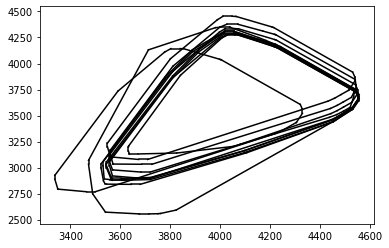

In [ ]:
hulls_x = []
hulls_y = []

for points_array in points:
    hull_x = []
    hull_y = []
    points_array = np.array(points_array)
    hull = ConvexHull(points_array)
    for simplex in hull.simplices:
        # print(points_array[simplex, 0], points_array[simplex, 1])
        hull_x.append(points_array[simplex, 0])
        hull_y.append(points_array[simplex, 1])
        plt.plot(points_array[simplex, 0], points_array[simplex, 1], 'k-')
    hulls_x.append(hull_x)
    hulls_y.append(hull_y)


4 20
5 20
6 19
6 20
10 20


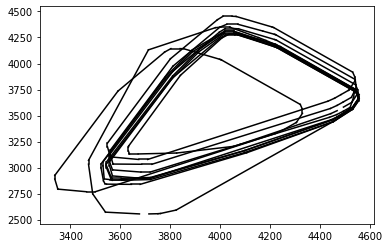

In [ ]:
# print(hulls_x)
# print(hulls_y)

for i in range(len(hulls_x)):
    for j in range(len(hulls_x[0])):
        try:
            plt.plot(hulls_x[i][j], hulls_y[i][j], 'k-')
        except:
            print(i,j)

4 20
5 20
6 19
6 20
10 20


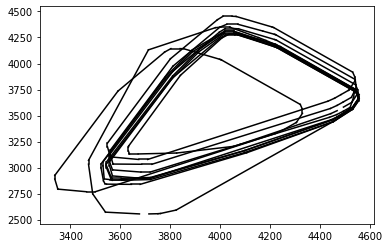

In [ ]:
hulls_x = shift_origin(hulls_x)
hulls_y = shift_origin(hulls_y)

for i in range(len(hulls_x)):
    for j in range(len(hulls_x[0])):
        try:
            plt.plot(hulls_x[i][j], hulls_y[i][j], 'k-')
        except:
            print(i,j)

# load chains

In [ ]:
chains = np.load("/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Model/chains.npy", allow_pickle=True)

# DTW

In [ ]:
def dtw(s, t):
    n, m = len(s), len(t)
    dtw_matrix = np.zeros((n+1, m+1))
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix

In [ ]:
for i in range(len(chains)):
    distance, path = fastdtw(chains[0], chains[i], dist=euclidean)
    print(distance, path)

0.0 [(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8), (9, 9), (10, 10), (11, 11), (12, 12), (13, 13), (14, 14), (15, 15), (16, 16), (17, 17), (18, 18), (19, 19), (20, 20), (21, 21), (22, 22), (23, 23), (24, 24), (25, 25), (26, 26), (27, 27), (28, 28), (29, 29), (30, 30), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35), (36, 36), (37, 37), (38, 38), (39, 39), (40, 40), (41, 41), (42, 42), (43, 43), (44, 44), (45, 45), (46, 46), (47, 47), (48, 48), (49, 49), (50, 50), (51, 51), (52, 52), (53, 53), (54, 54), (55, 55), (56, 56), (57, 57), (58, 58), (59, 59), (60, 60), (61, 61), (62, 62), (63, 63), (64, 64), (65, 65), (66, 66), (67, 67), (68, 68), (69, 69), (70, 70), (71, 71), (72, 72), (73, 73), (74, 74), (75, 75), (76, 76), (77, 77), (78, 78), (79, 79), (80, 80), (81, 81), (82, 82), (83, 83), (84, 84), (85, 85), (86, 86), (87, 87), (88, 88), (89, 89), (90, 90), (91, 91), (92, 92), (93, 93), (94, 94), (95, 95), (96, 96), (97, 97), (98, 98), (99, 99), (100, 100), (10

# chain code differentation

In [ ]:
def chain_analysis(new_chain):
    print("-"*30)

    data_pattern = []

    already_covered = []
    data_current = {}
    count = 0
    for i in range(len(new_chain)-1):
        if new_chain[i] in already_covered:
            data_pattern.append(data_current)
            already_covered = []
            data_current = {}
            count = 1
        else:
            if new_chain[i] == new_chain[i+1]:
                count += 1
            else:
                count += 1

                data_current[new_chain[i]] = count
                already_covered.append(new_chain[i])
                count = 0

    # print("Data :", data_pattern)
    print("Initial Data :", len(data_pattern))

    skip_index = []
    data_pattern_less_than_3 = []
    for i in range(len(data_pattern)):
        if i in skip_index:
            continue
        elif max(data_pattern[i].values()) >= 10 and len(data_pattern[i].values()) <= 3:
            pos = list(data_pattern[i].keys())[list(data_pattern[i].values()).index(max(data_pattern[i].values()))]

            if data_pattern[(i+1)%len(data_pattern)].get(pos):
                skip_index.append(i+1)
                out = data_pattern[(i)%len(data_pattern)].get(pos) + data_pattern[(i+1)%len(data_pattern)].get(pos)
                data_pattern_less_than_3.append({pos: out})
            else:
                data_pattern_less_than_3.append(data_pattern[i])
        else:
            data_pattern_less_than_3.append(data_pattern[i])


    # print("Data with spikes less than 3 normalized :", data_pattern_less_than_3)
    print("Data with spikes less than 3 pixel noise is normalized :", len(data_pattern_less_than_3))

    skip_index = []
    data_pattern_range_1 = []
    for i in range(len(data_pattern)):
        arr = []
        for j in range(len(data_pattern[i].keys())):
            if j != list(data_pattern[i].values()).index(max(data_pattern[i].values())):
                mul = data_pattern[i][list(data_pattern[i].keys())[j]] * list(data_pattern[i].keys())[j]
                arr.append(mul)

        if i in skip_index:
            continue
        elif max(data_pattern[i].values()) >= 10 and -1 <= (sum(arr) % 8) <= 1:
            pos = list(data_pattern[i].keys())[list(data_pattern[i].values()).index(max(data_pattern[i].values()))]

            if data_pattern[(i+1)%len(data_pattern)].get(pos):
                skip_index.append(i+1)
                out = data_pattern[(i)%len(data_pattern)].get(pos) + data_pattern[(i+1)%len(data_pattern)].get(pos)
                data_pattern_range_1.append({pos: out})
            else:
                data_pattern_range_1.append(data_pattern[i])
        else:
            data_pattern_range_1.append(data_pattern[i])

    # print("Data with spikes resultant between -1, 1 normalized :", data_pattern_range_1)
    print("Data with spikes resultant between -1, 1 normalized :", len(data_pattern_range_1))

    skip_index = []
    data_pattern_exact_0 = []
    for i in range(len(data_pattern)):
        arr = []
        for j in range(len(data_pattern[i].keys())):
            if j != list(data_pattern[i].values()).index(max(data_pattern[i].values())):
                mul = data_pattern[i][list(data_pattern[i].keys())[j]] * list(data_pattern[i].keys())[j]
                arr.append(mul)

        if i in skip_index:
            continue
        elif max(data_pattern[i].values()) >= 10 and sum(arr) == 0:
            pos = list(data_pattern[i].keys())[list(data_pattern[i].values()).index(max(data_pattern[i].values()))]

            if data_pattern[(i+1)%len(data_pattern)].get(pos):
                skip_index.append(i+1)
                out = data_pattern[(i)%len(data_pattern)].get(pos) + data_pattern[(i+1)%len(data_pattern)].get(pos)
                data_pattern_exact_0.append({pos: out})
            else:
                data_pattern_exact_0.append(data_pattern[i])
        else:
            data_pattern_exact_0.append(data_pattern[i])

    # print("Data with spikes resultant to be normalized :", data_pattern_exact_0)
    print("Data with spikes resultant to be normalized :", len(data_pattern_exact_0))

    print("-"*30)

    return data_pattern, data_pattern_less_than_3, data_pattern_range_1, data_pattern_exact_0
    

In [ ]:
arr_for_hists_for_data_pattern = []
arr_for_hists_for_data_pattern_less_than_3 = []
arr_for_hists_for_data_pattern_range_1 = []
arr_for_hists_for_data_pattern_exact_0 = []


for chain in chains:
    # new_chain = []
    # for i in range(len(chain)):
    #     new_chain.append(chain[i]-chain[(i+1)%len(chain)])

    new_chain = chain
    data_pattern, data_pattern_less_than_3, data_pattern_range_1, data_pattern_exact_0 = chain_analysis(new_chain)
    
    arr_for_hist_data_pattern = []
    arr_for_hist_data_pattern_less_than_3 = []
    arr_for_hist_data_pattern_range_1 = []
    arr_for_hist_data_pattern_exact_0 = []

    for i in data_pattern:
        arr_for_hist_data_pattern.append(max(i.values()))

    for i in data_pattern_less_than_3:
        arr_for_hist_data_pattern_less_than_3.append(max(i.values()))

    for i in data_pattern_range_1:
        arr_for_hist_data_pattern_range_1.append(max(i.values()))

    for i in data_pattern_exact_0:
        arr_for_hist_data_pattern_exact_0.append(max(i.values()))

    arr_for_hists_for_data_pattern.append(arr_for_hist_data_pattern)
    arr_for_hists_for_data_pattern_less_than_3.append(arr_for_hist_data_pattern_less_than_3)
    arr_for_hists_for_data_pattern_range_1.append(arr_for_hist_data_pattern_range_1)
    arr_for_hists_for_data_pattern_exact_0.append(arr_for_hist_data_pattern_exact_0)


------------------------------
Initial Data : 545
Data with spikes less than 3 normalized : 474
Data with spikes resultant between -1, 1 normalized : 514
Data with spikes resultant to be normalized : 530
------------------------------
------------------------------
Initial Data : 668
Data with spikes less than 3 normalized : 590
Data with spikes resultant between -1, 1 normalized : 624
Data with spikes resultant to be normalized : 645
------------------------------
------------------------------
Initial Data : 882
Data with spikes less than 3 normalized : 775
Data with spikes resultant between -1, 1 normalized : 814
Data with spikes resultant to be normalized : 845
------------------------------
------------------------------
Initial Data : 582
Data with spikes less than 3 normalized : 504
Data with spikes resultant between -1, 1 normalized : 554
Data with spikes resultant to be normalized : 567
------------------------------
------------------------------
Initial Data : 609
Data with 

# histogram

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


(array([[405.,  42.,  19.,  41.,  25.,  10.,   1.,   2.,   0.,   0.],
        [516.,  57.,  35.,  36.,  13.,  11.,   0.,   0.,   0.,   0.],
        [746.,  71.,  27.,  20.,  18.,   0.,   0.,   0.,   0.,   0.],
        [438.,  47.,  15.,  40.,  30.,   6.,   3.,   3.,   0.,   0.],
        [494.,  11.,  37.,  51.,   6.,   5.,   5.,   0.,   0.,   0.],
        [839.,  43.,  25.,  51.,   8.,   0.,   0.,   0.,   0.,   0.],
        [527.,  60.,  19.,  47.,  15.,   6.,   2.,   0.,   0.,   0.],
        [512.,  45.,  21.,  50.,  17.,   4.,   1.,   0.,   0.,   1.],
        [442.,  39.,  19.,  35.,  21.,   7.,   0.,   0.,   0.,   0.],
        [506.,  59.,  25.,  40.,  39.,   8.,   0.,   1.,   1.,   0.],
        [444.,  48.,  16.,  47.,  19.,   8.,   3.,   2.,   0.,   0.]]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 11 Lists of Patches objects>)

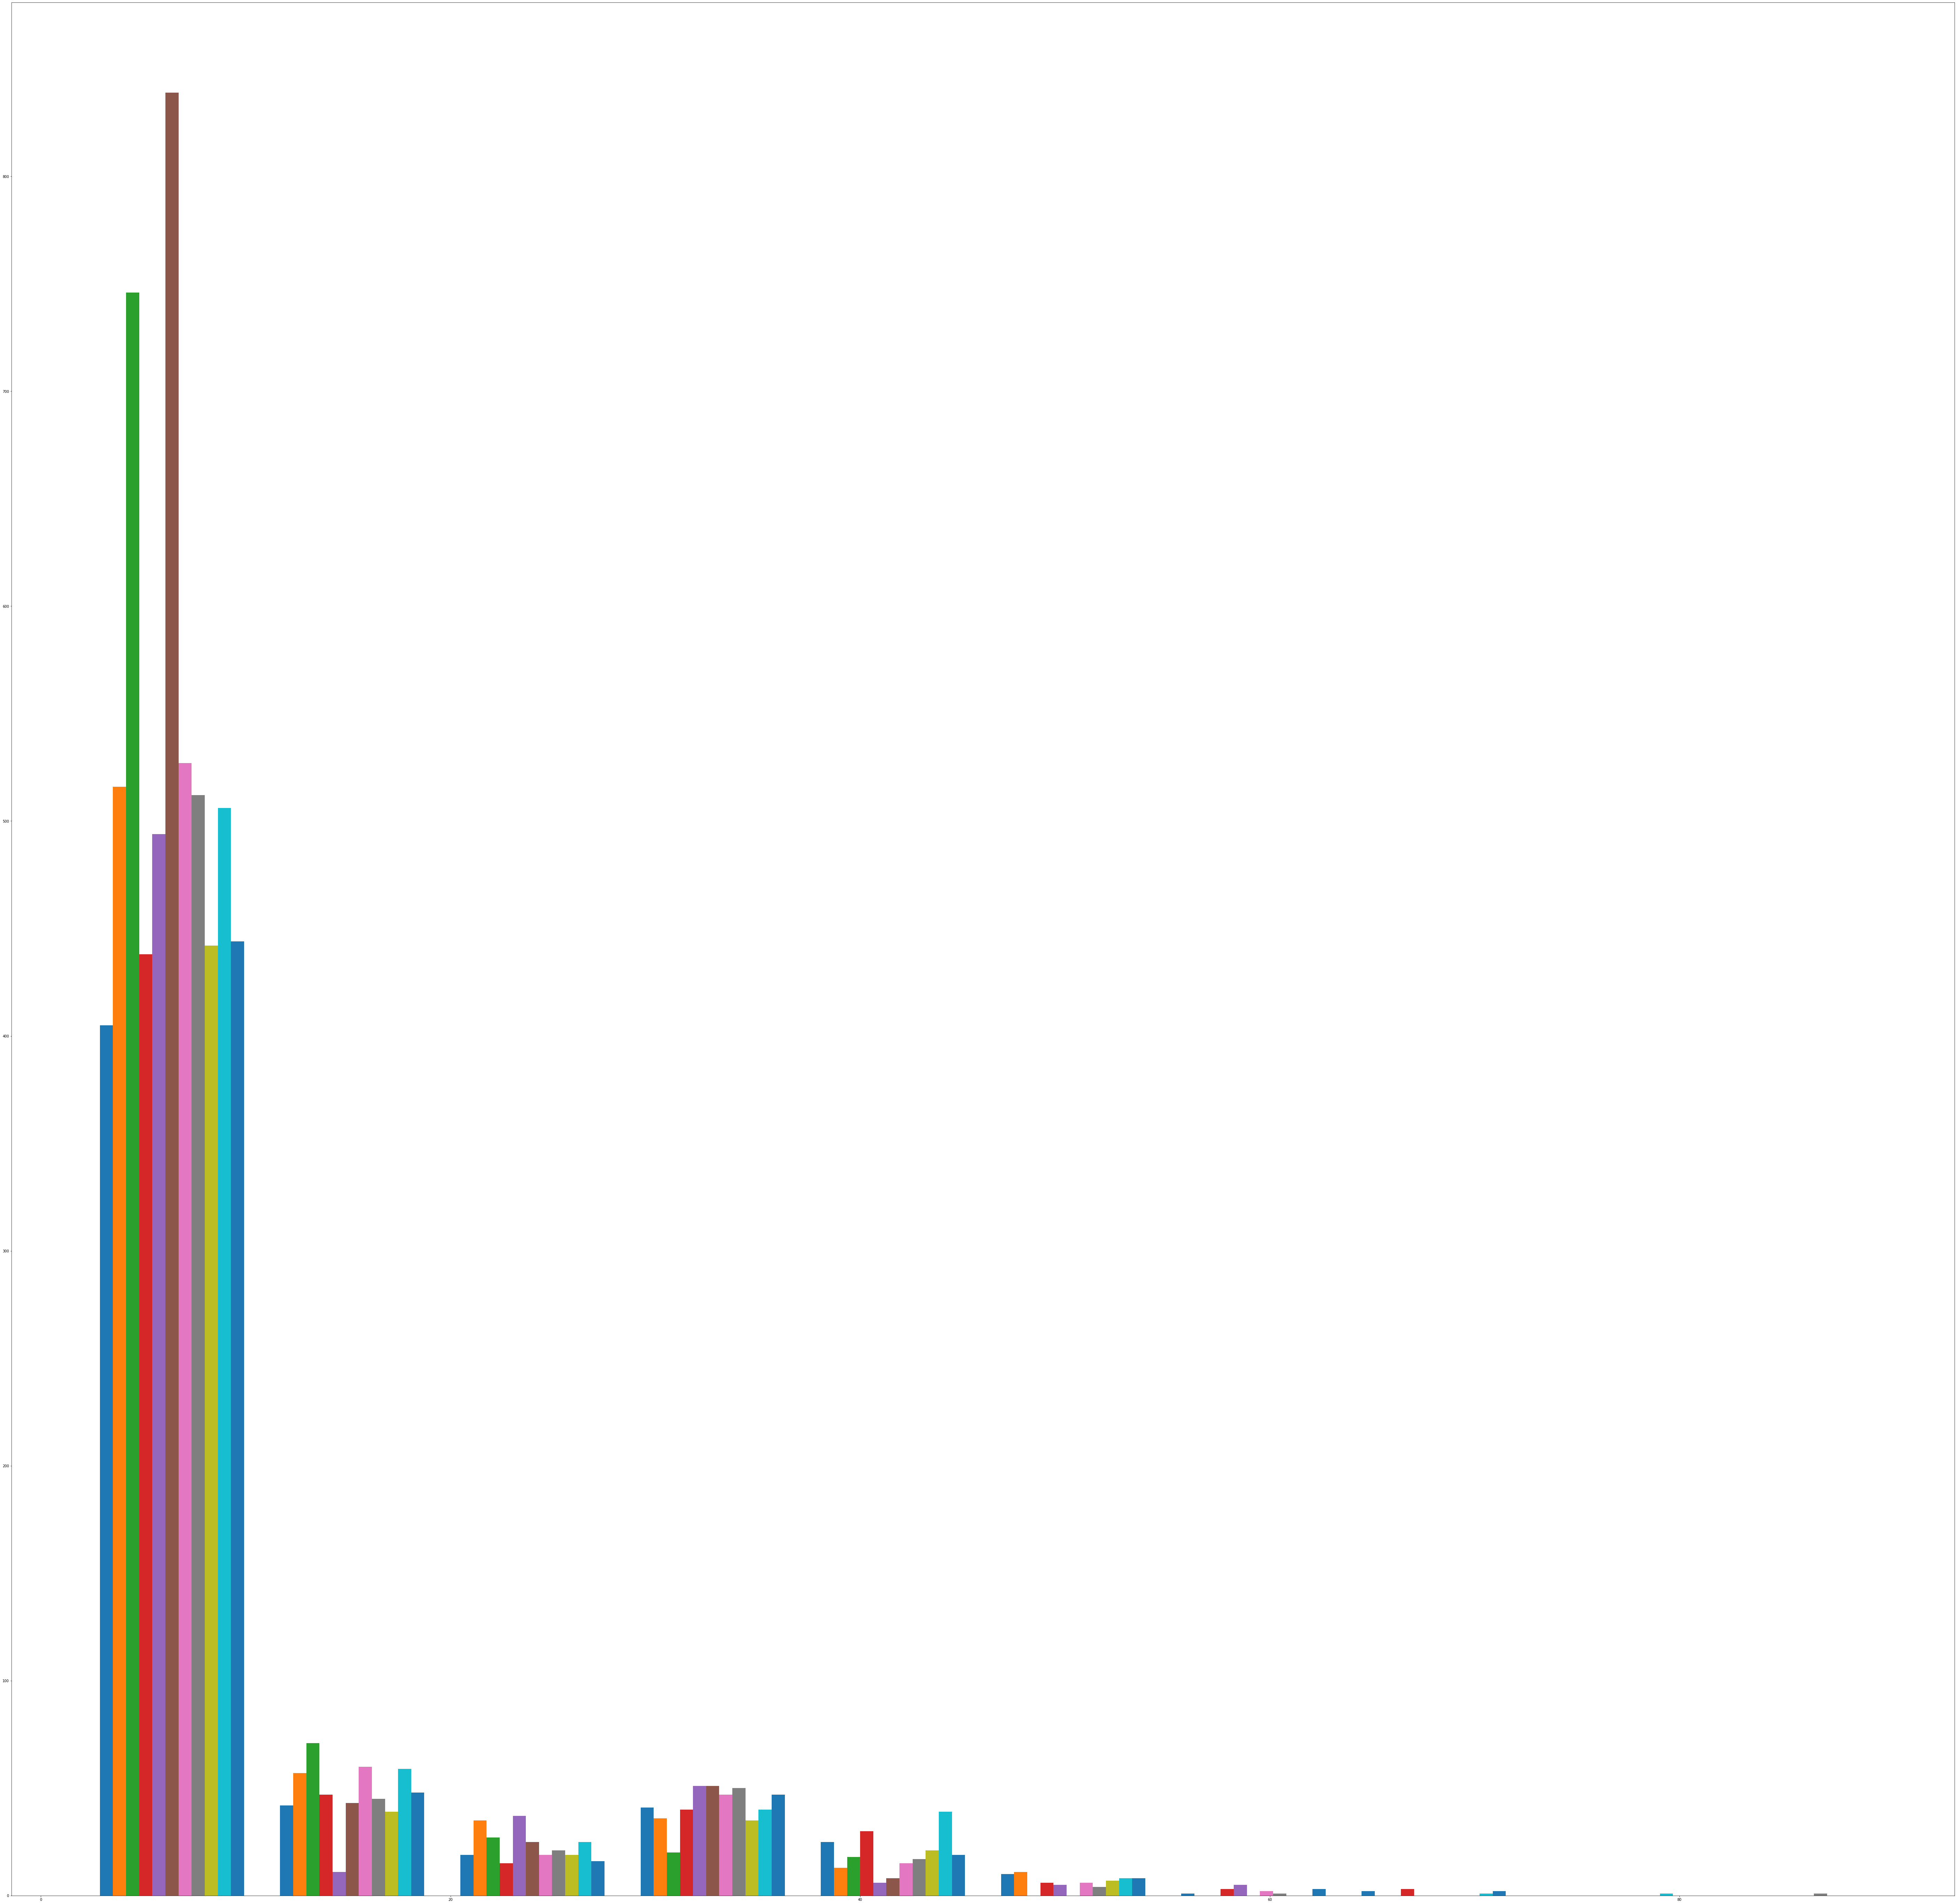

In [ ]:
plt.figure(figsize=(100,100)) 
plt.hist(arr_for_hists_for_data_pattern)

(array([[348.,  31.,  16.,  30.,  26.,  13.,   3.,   4.,   3.,   0.],
        [453.,  41.,  22.,  40.,  14.,  18.,   2.,   0.,   0.,   0.],
        [635.,  61.,  37.,  14.,  28.,   0.,   0.,   0.,   0.,   0.],
        [383.,  31.,  12.,  33.,  23.,   7.,   3.,   5.,   6.,   1.],
        [454.,  11.,  16.,  45.,  18.,  10.,   5.,   0.,   0.,   0.],
        [765.,  40.,  16.,  42.,  22.,   4.,   0.,   0.,   0.,   0.],
        [450.,  47.,  21.,  40.,  24.,   6.,   2.,   0.,   1.,   1.],
        [442.,  37.,  22.,  43.,  16.,   8.,   6.,   0.,   0.,   1.],
        [379.,  34.,  19.,  32.,  21.,   9.,   2.,   1.,   1.,   0.],
        [417.,  46.,  30.,  34.,  36.,  12.,   6.,   1.,   2.,   0.],
        [394.,  32.,  16.,  35.,  18.,  11.,   3.,   4.,   5.,   0.]]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 11 Lists of Patches objects>)

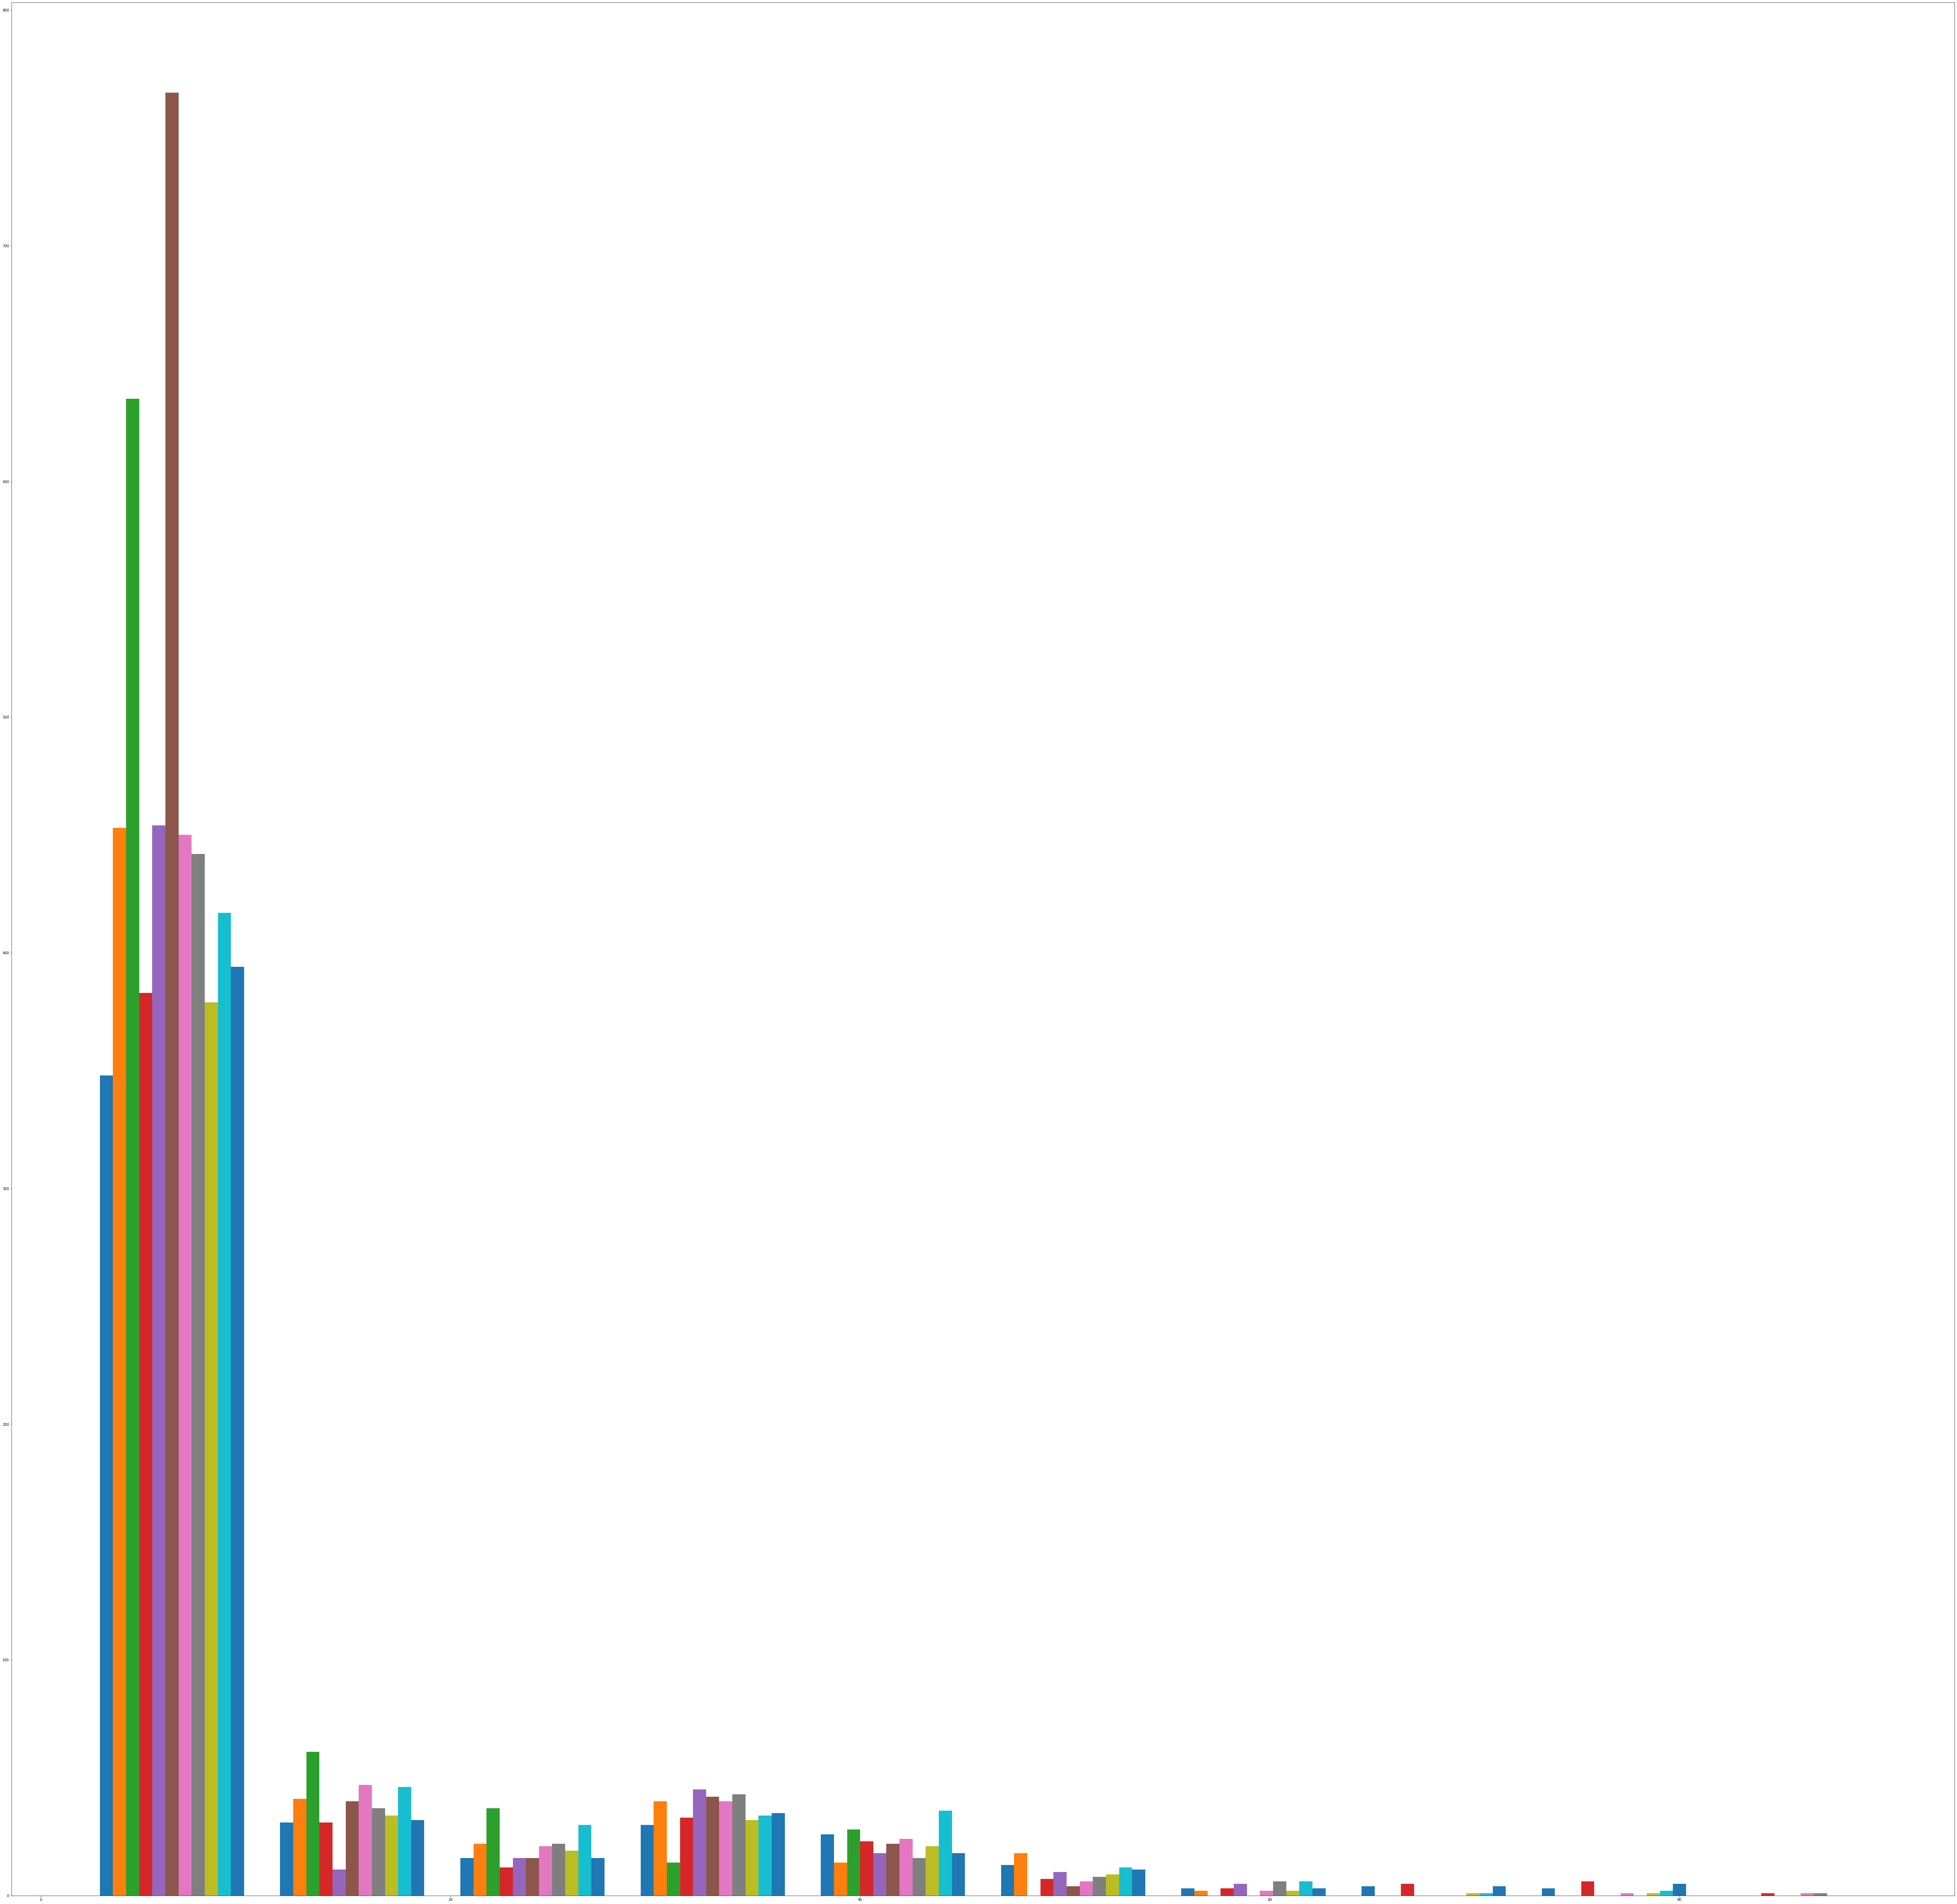

In [ ]:
plt.figure(figsize=(100,100)) 
plt.hist(arr_for_hists_for_data_pattern_less_than_3)

(array([[383.,  34.,  16.,  41.,  22.,  12.,   3.,   2.,   1.,   0.],
        [477.,  49.,  32.,  41.,  11.,  13.,   1.,   0.,   0.,   0.],
        [669.,  80.,  27.,  15.,  23.,   0.,   0.,   0.,   0.,   0.],
        [415.,  40.,  19.,  37.,  28.,   6.,   4.,   3.,   2.,   0.],
        [472.,  11.,  31.,  51.,  12.,   5.,   5.,   0.,   0.,   0.],
        [809.,  43.,  16.,  60.,   8.,   0.,   0.,   0.,   0.,   0.],
        [500.,  54.,  19.,  45.,  19.,   7.,   1.,   0.,   1.,   0.],
        [480.,  46.,  19.,  49.,  18.,   5.,   2.,   0.,   0.,   1.],
        [411.,  38.,  17.,  32.,  24.,   9.,   1.,   0.,   0.,   0.],
        [481.,  51.,  24.,  37.,  35.,   9.,   3.,   2.,   3.,   0.],
        [426.,  44.,  16.,  46.,  16.,  10.,   3.,   2.,   2.,   0.]]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 11 Lists of Patches objects>)

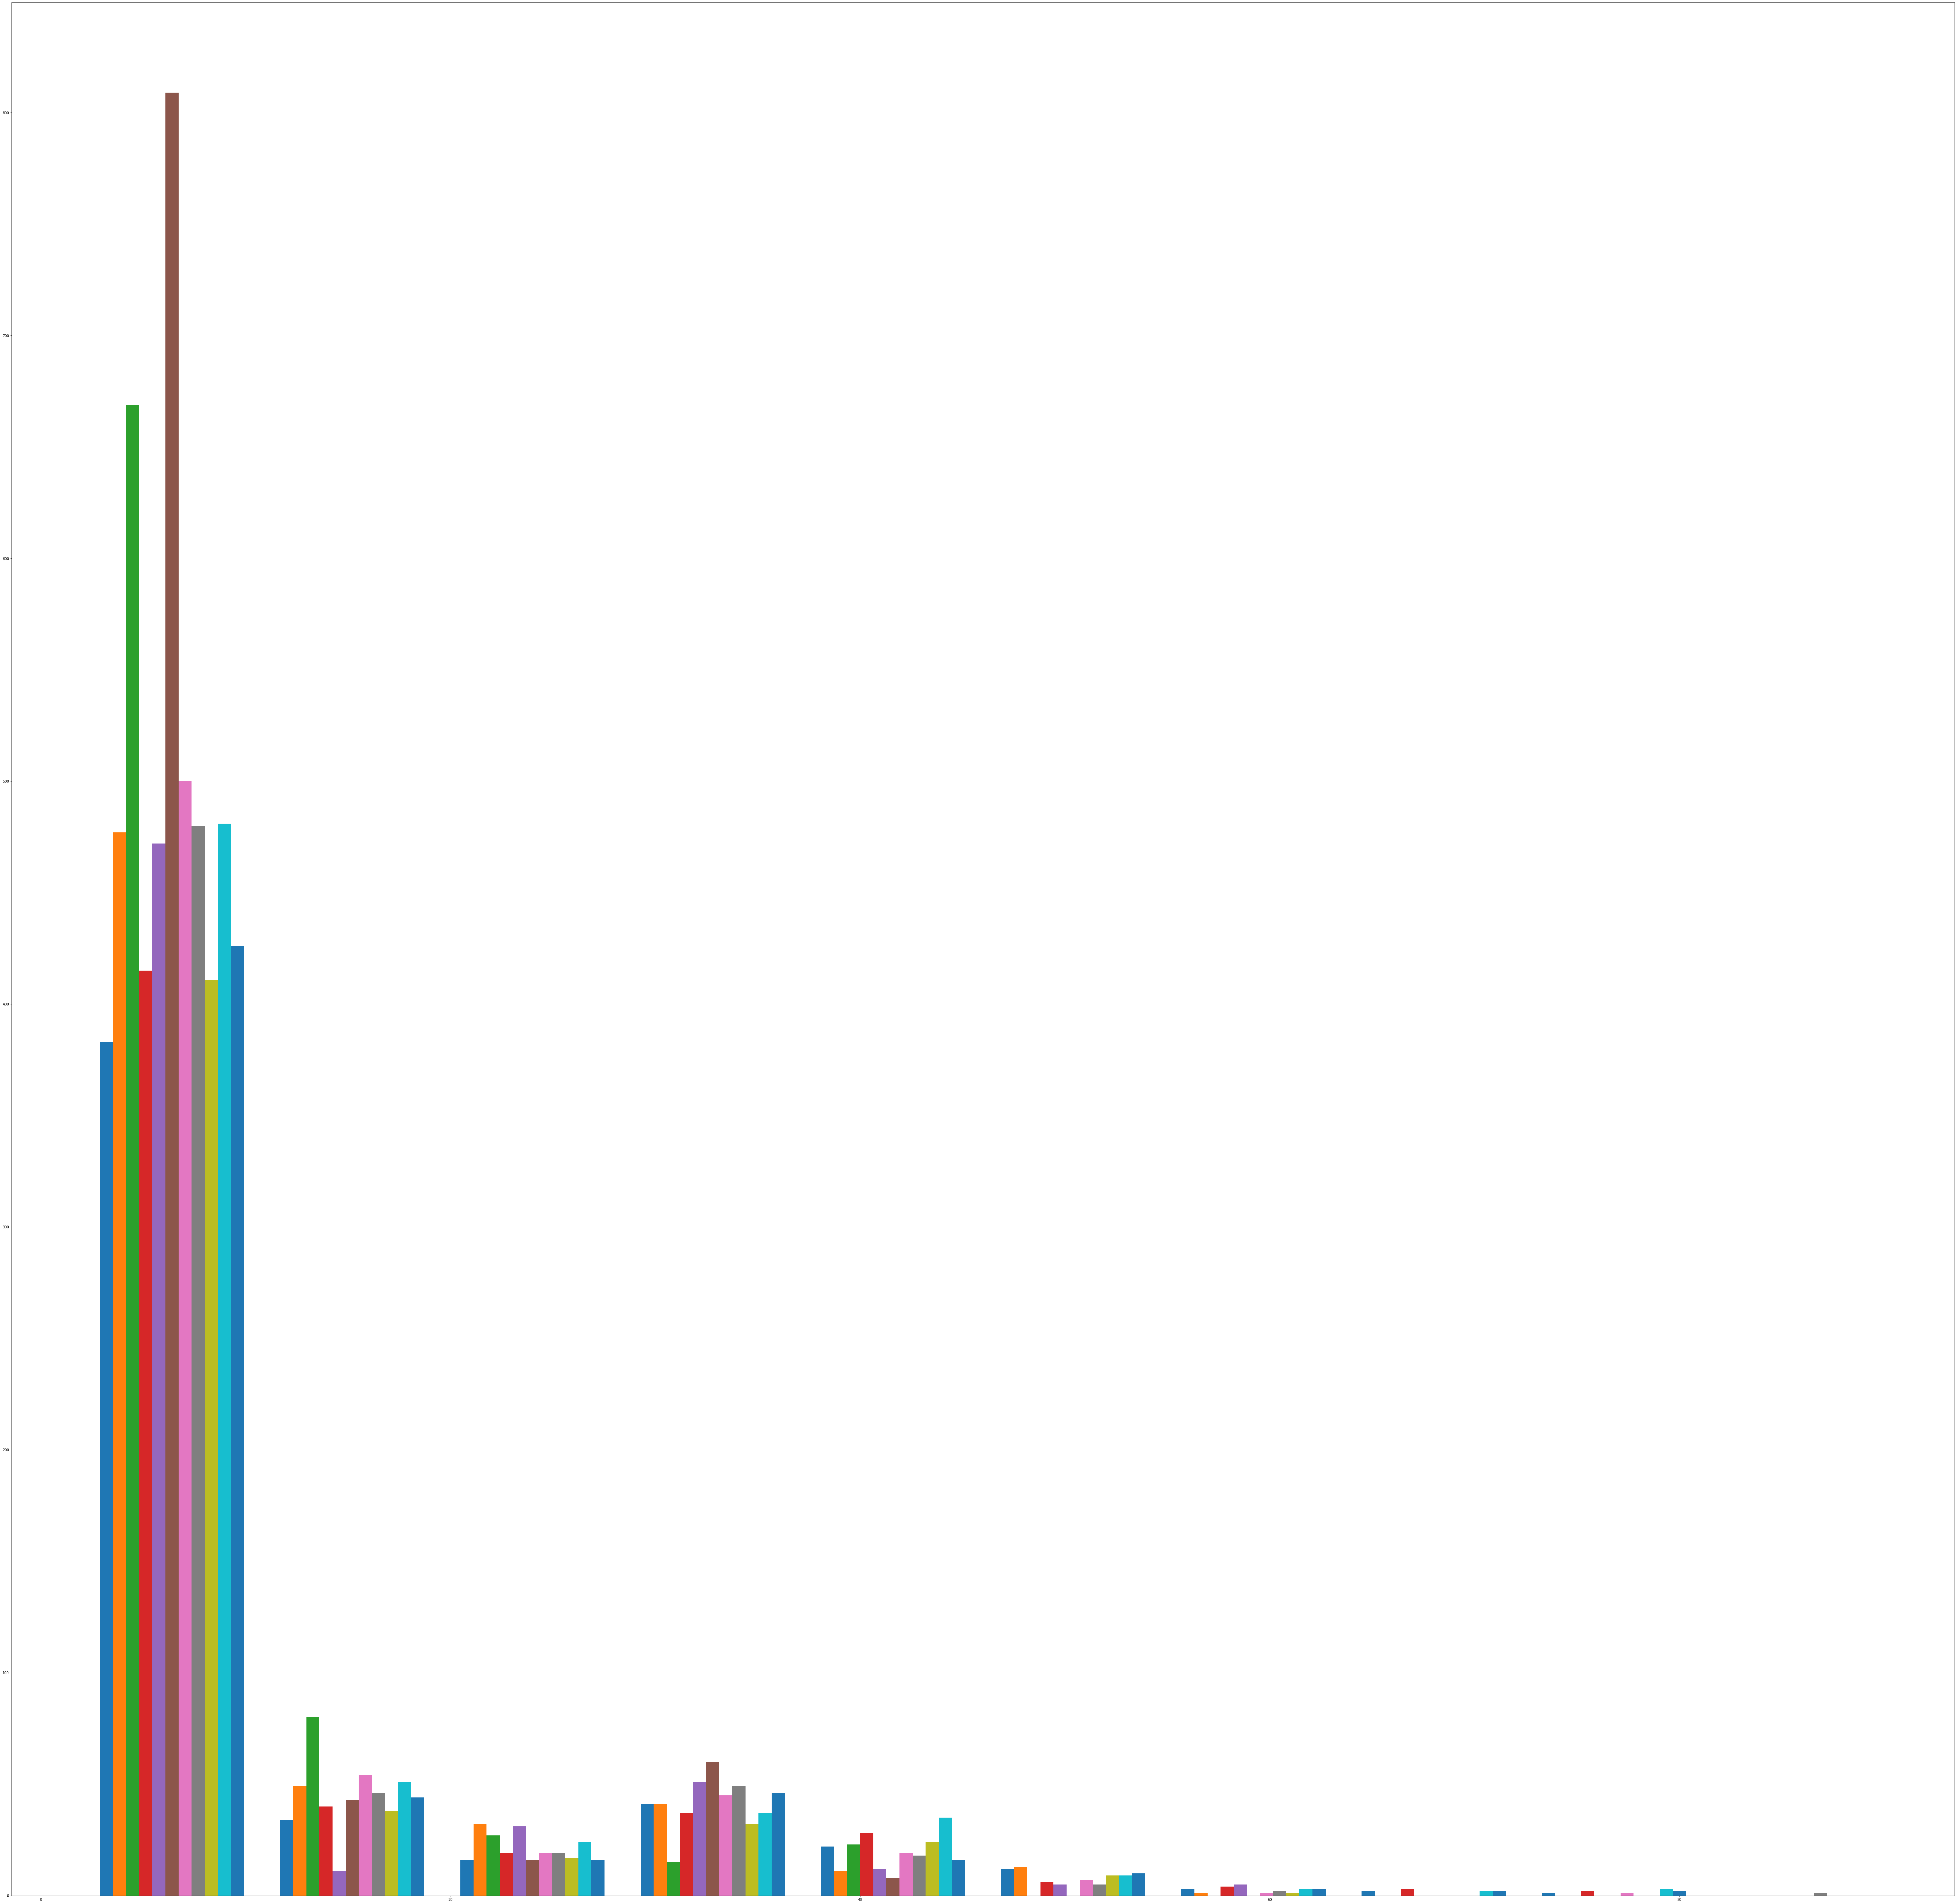

In [ ]:
plt.figure(figsize=(100,100)) 
plt.hist(arr_for_hists_for_data_pattern_range_1)

(array([[392.,  39.,  18.,  41.,  24.,  12.,   2.,   2.,   0.,   0.],
        [496.,  51.,  35.,  38.,  14.,  11.,   0.,   0.,   0.,   0.],
        [700.,  80.,  27.,  20.,  18.,   0.,   0.,   0.,   0.,   0.],
        [425.,  42.,  17.,  41.,  29.,   6.,   4.,   3.,   0.,   0.],
        [488.,  11.,  31.,  57.,   6.,   5.,   5.,   0.,   0.,   0.],
        [823.,  43.,  21.,  55.,   8.,   0.,   0.,   0.,   0.,   0.],
        [511.,  55.,  20.,  48.,  15.,   7.,   1.,   0.,   1.,   0.],
        [499.,  45.,  21.,  50.,  17.,   5.,   1.,   0.,   0.,   1.],
        [432.,  40.,  19.,  33.,  23.,   7.,   0.,   0.,   0.,   0.],
        [497.,  58.,  27.,  39.,  38.,   8.,   0.,   1.,   2.,   0.],
        [435.,  45.,  17.,  48.,  19.,   8.,   3.,   2.,   0.,   0.]]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 11 Lists of Patches objects>)

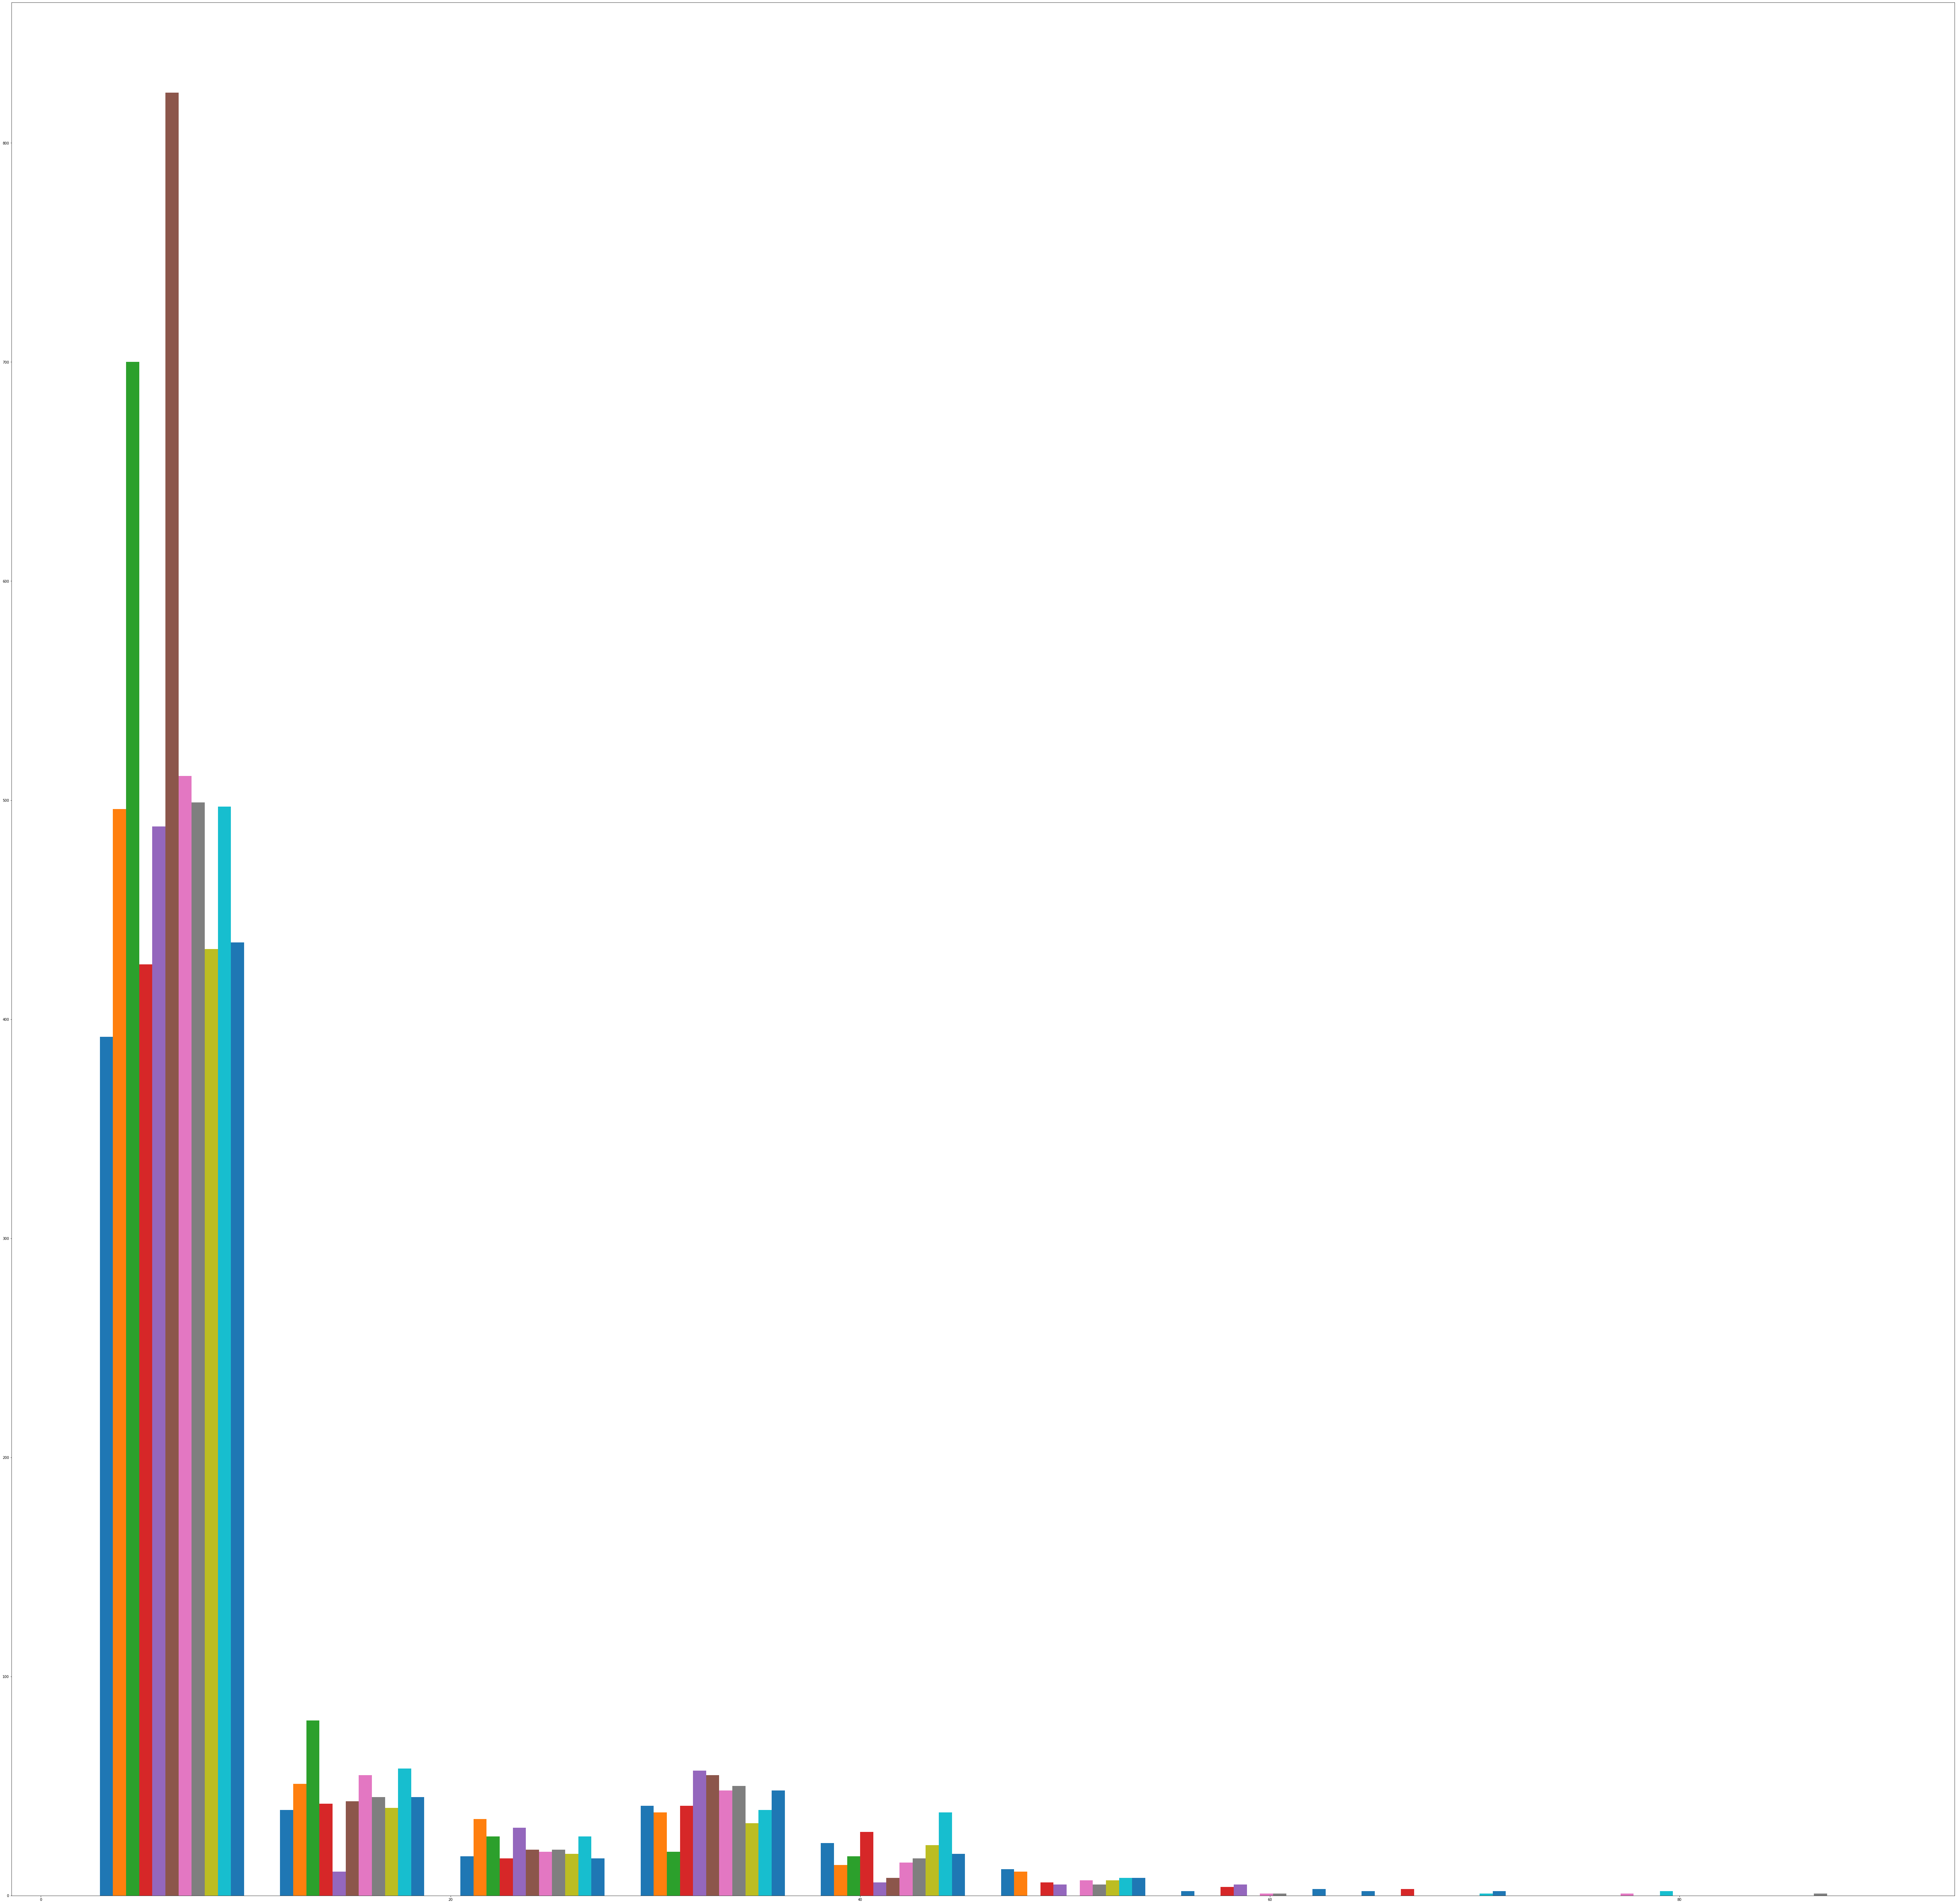

In [ ]:
plt.figure(figsize=(100,100)) 
plt.hist(arr_for_hists_for_data_pattern_exact_0)

# crop images in to sections

In [ ]:
dh = 1024
dw = 1024

for image in os.listdir(processed_images_path):
    name, ext = os.path.splitext(image)
    img = Image.open(os.path.join(processed_images_path, image))
    w, h = img.size

    grid = product(range(0, h-(h % dh), dh), range(0, w-(w % dw), dw))
    for i, j in grid:
        if j+dw <= w:
            box = (j, i, j+dw, i+dh)
            out = os.path.join(
                "/content/drive/MyDrive/Projects/3rd-Year-Project/NDWI/Cropped/", f'{name}{j}x{i}_{j+dw}x{i+dh}{ext}')
            cropped_img = img.crop(box)
            np_cropped_img = np.asarray(cropped_img)
            print()
            if np.all(np_cropped_img == np_cropped_img[0]):
                continue
            else:
                cropped_img.save(out)

OSError: ignored